In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv
import HelperFunctions as hf
import os 
import tarfile
import zipfile


# Overview

[M5 forecasting challenge](https://www.kaggle.com/c/m5-forecasting-accuracy/data)


## Data Description

- `calendar.csv` - Contains information about the dates on which the products are sold.

- `sales_train_validation.csv` - Contains the historical daily unit sales data per product and store `[d_1 - d_1913]`

- `sell_prices.csv` - Contains information about the price of the products sold per store and date.

- `sample_submission.csv` - The correct format for submissions. Reference the [Evaluation](https://www.kaggle.com/c/m5-forecasting-accuracy/overview/evaluation) tab for more info.

- `sales_train_evaluation.csv` - Includes sales `[d_1 - d_1941]` (labels used for the Public leaderboard)


## Task

- Forecast daily sales for the next 28 days



# 1. Download the Data

In [2]:
%%bash

kaggle competitions download m5-forecasting-accuracy -p data


100%|██████████| 45.8M/45.8M [00:08<00:00, 5.78MB/s]


In [3]:
def fetch_walmat_data():
    zip_path = os.path.join('data', 'm5-forecasting-accuracy.zip')    
    
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('data')
    
    print(zip_ref.namelist())

fetch_walmat_data()


['calendar.csv', 'sales_train_evaluation.csv', 'sales_train_validation.csv', 'sample_submission.csv', 'sell_prices.csv']


# 2. Read the Data

In [4]:
def load_calendar_data():    
    csv_path = os.path.join('data', 'calendar.csv')
    return pd.read_csv(csv_path)


def load_sell_price_data():
    csv_path = os.path.join('data', 'sell_prices.csv')
    return pd.read_csv(csv_path)


def load_sales_train_validation_data():
    csv_path = os.path.join('data', 'sales_train_validation.csv')
    return pd.read_csv(csv_path)


def load_sales_train_evaluation_data():
    csv_path = os.path.join('data', 'sales_train_evaluation.csv')
    return pd.read_csv(csv_path)


## 2.1 Read Calendar

In [5]:
calendar = load_calendar_data()
calendar.head()


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [6]:
print(f'shape: {calendar.shape}\n')

calendar.info()

shape: (1969, 14)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
date            1969 non-null object
wm_yr_wk        1969 non-null int64
weekday         1969 non-null object
wday            1969 non-null int64
month           1969 non-null int64
year            1969 non-null int64
d               1969 non-null object
event_name_1    162 non-null object
event_type_1    162 non-null object
event_name_2    5 non-null object
event_type_2    5 non-null object
snap_CA         1969 non-null int64
snap_TX         1969 non-null int64
snap_WI         1969 non-null int64
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


### Sweetviz

In [22]:
# quick eda by sweetViz
calendar_report = sv.analyze(calendar)

# display the report
calendar_report.show_html('Calendar.html')



Report Calendar.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


# Create the melted dataframe for further analysis

In [7]:
#Read data files
price_df = load_sell_price_data()
sales_df = load_sales_train_evaluation_data()

In [35]:
#Create the melted dataframe
df = hf.meltM5(sales_df, days = 730, items = 15000)

In [36]:
#Join with calendar and price data
df = hf.joinDataSets(df, calendar, price_df, dropPriceNA=False)

Initial inspection of the raw data

In [37]:
df.shape

(6392217, 22)

In [38]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
3,FOODS_3_504_CA_1_evaluation,FOODS_3_504,FOODS_3,FOODS,CA_1,CA,d_1,5,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,1.00
5,FOODS_1_101_TX_1_evaluation,FOODS_1_101,FOODS_1,FOODS,TX_1,TX,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,1.97
9,FOODS_3_230_TX_2_evaluation,FOODS_3_230,FOODS_3,FOODS,TX_2,TX,d_1,5,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,3.26
10,HOUSEHOLD_1_126_CA_3_evaluation,HOUSEHOLD_1_126,HOUSEHOLD_1,HOUSEHOLD,CA_3,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,7.97
11,FOODS_2_153_CA_4_evaluation,FOODS_2_153,FOODS_2,FOODS,CA_4,CA,d_1,1,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,2.73


In [39]:
df.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sold', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price'],
      dtype='object')

In [40]:
df.describe()

,sold,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI,sell_price
count,6.392217e+06,6.392217e+06,6.392217e+06,6.392217e+06,6.392217e+06,6.392217e+06,6.392217e+06,6.392217e+06,6.392217e+06
mean,1.704536e+00,1.118478e+04,3.991418e+00,6.692880e+00,2.011650e+03,3.264026e-01,3.273687e-01,3.274349e-01,4.336784e+00
std,5.397050e+00,5.196915e+01,2.002126e+00,3.471880e+00,5.651215e-01,4.688965e-01,4.692531e-01,4.692774e-01,3.188811e+00
min,0.000000e+00,1.110100e+04,1.000000e+00,1.000000e+00,2.011000e+03,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e-02
25%,0.000000e+00,1.113200e+04,2.000000e+00,4.000000e+00,2.011000e+03,0.000000e+00,0.000000e+00,0.000000e+00,2.080000e+00
50%,0.000000e+00,1.120800e+04,4.000000e+00,7.000000e+00,2.012000e+03,0.000000e+00,0.000000e+00,0.000000e+00,3.470000e+00
75%,2.000000e+00,1.123100e+04,6.000000e+00,1.000000e+01,2.012000e+03,1.000000e+00,1.000000e+00,1.000000e+00,5.840000e+00
max,6.930000e+02,1.130100e+04,7.000000e+00,1.200000e+01,2.013000e+03,1.000000e+00,1.000000e+00,1.000000e+00,6.146000e+01


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6392217 entries, 3 to 10949999
Data columns (total 22 columns):
id              object
item_id         object
dept_id         object
cat_id          object
store_id        object
state_id        object
d               object
sold            int64
date            object
wm_yr_wk        int64
weekday         object
wday            int64
month           int64
year            int64
event_name_1    object
event_type_1    object
event_name_2    object
event_type_2    object
snap_CA         int64
snap_TX         int64
snap_WI         int64
sell_price      float64
dtypes: float64(1), int64(8), object(13)
memory usage: 1.1+ GB


In [42]:
#These are likely seasonal products, such as xmas trees, or brussel sprouts
print("Percentage of products that are not on sale: ", df['sell_price'].isna().sum() / len(df['sell_price']) * 100)

Percentage of products that are not on sale:  0.0


In [19]:
#Function for plotting time series over a group in the data
def GroupTimeSeriesPlot(by):
    group = df[[by,'d','sold']].groupby([by,'d'], as_index=False).sum()
    days = np.array(list(range(1, 731)))

    for cat in np.unique(group[by]):
        category = np.array(group[group[by]==cat]['sold'])
        plt.plot(days, category, label=cat)
        plt.legend()

    plt.xlabel('Day')
    plt.ylabel('Items Sold')
    plt.title('Time Series Plot of Items Sold')
    plt.show()

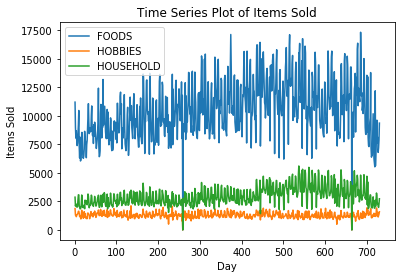

In [20]:
###Finding yearly trends for different product categories
GroupTimeSeriesPlot(by='cat_id')

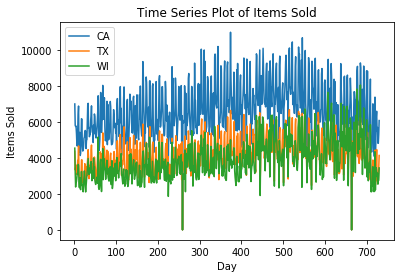

In [21]:
#Time series by state
GroupTimeSeriesPlot(by='state_id')

In [43]:
#Create the dataframe with dropped items when they are not on sale
df = hf.meltM5(sales_df, days = 730, items = 15000)
df = hf.joinDataSets(df, calendar, price_df, dropPriceNA=True)

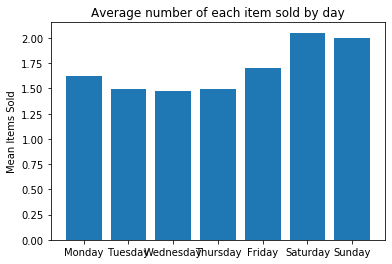

In [71]:
#Mean number of sales per item by day
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
days = df[['sold','weekday']].groupby(['weekday']).mean().reindex(cats) 
plt.bar(days.index, days['sold'])
plt.ylabel('Mean Items Sold')
plt.title('Average number of each item sold by day')
plt.show()

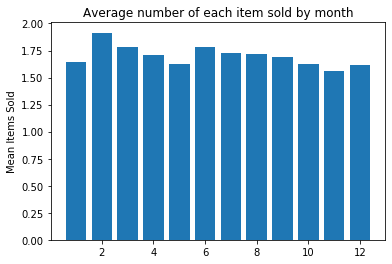

In [93]:
#Mean number of sales per item by month
months = df[['sold','month']].groupby(['month']).mean()
plt.bar(months.index, months['sold'])
plt.ylabel('Mean Items Sold')
plt.title('Average number of each item sold by month')
plt.show()

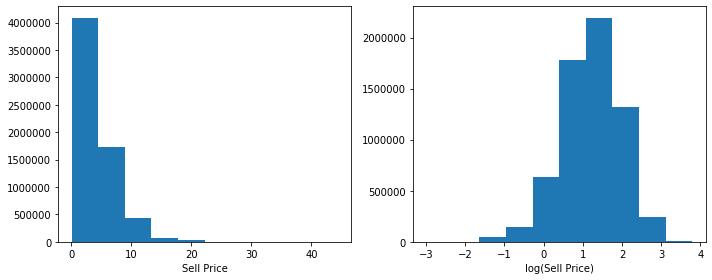

In [81]:
#Histogram of item sell prices
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
ax[0].hist(df['sell_price'])
ax[1].hist(np.log(df['sell_price']))
ax[0].set_xlabel('Sell Price')
ax[1].set_xlabel('log(Sell Price)')
plt.tight_layout()
plt.show()

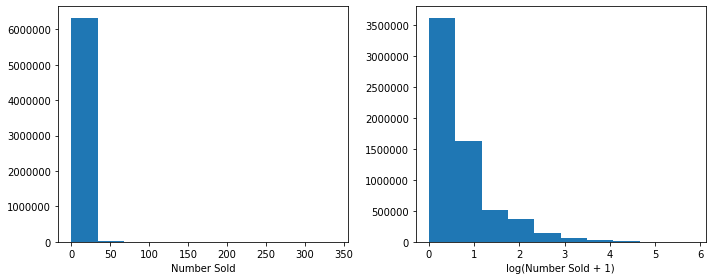

In [86]:
#Histogram of number of items sold
#Had to plus 1 because several values are zero
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
ax[0].hist(df['sold'])
ax[1].hist(np.log(1 + df['sold']))
ax[0].set_xlabel('Number Sold')
ax[1].set_xlabel('log(Number Sold + 1)')
plt.tight_layout()
plt.show()

# Analysing Events

In [102]:
np.unique(df['event_name_1'].astype(str))

array(['Chanukah End', 'Christmas', 'Cinco De Mayo', 'ColumbusDay',
       'Easter', 'Eid al-Fitr', 'EidAlAdha', "Father's day", 'Halloween',
       'IndependenceDay', 'LaborDay', 'LentStart', 'LentWeek2',
       'MartinLutherKingDay', 'MemorialDay', "Mother's day",
       'NBAFinalsEnd', 'NBAFinalsStart', 'NewYear', 'OrthodoxChristmas',
       'OrthodoxEaster', 'Pesach End', 'PresidentsDay', 'Purim End',
       'Ramadan starts', 'StPatricksDay', 'SuperBowl', 'Thanksgiving',
       'ValentinesDay', 'VeteransDay', 'nan'], dtype=object)

In [106]:
np.unique(df['event_type_1'].astype(str))

array(['Cultural', 'National', 'Religious', 'Sporting', 'nan'],
      dtype=object)

In [107]:
np.unique(df['event_name_2'].astype(str))

array(['Easter', 'nan'], dtype=object)

In [108]:
np.unique(df['event_type_2'].astype(str))

array(['Cultural', 'nan'], dtype=object)

In [110]:
df['event_name_1'].astype(str).value_counts()

nan                    5846968
MartinLutherKingDay      19259
OrthodoxChristmas        19125
NewYear                  19027
Christmas                18967
Chanukah End             18947
Thanksgiving             18754
VeteransDay              18709
Halloween                18639
EidAlAdha                18575
ColumbusDay              18360
LaborDay                 18093
Eid al-Fitr              17998
Ramadan starts           17605
IndependenceDay          17315
Father's day             17155
NBAFinalsEnd             17133
NBAFinalsStart           17043
MemorialDay              16994
Mother's day             16795
Cinco De Mayo            16682
Pesach End               16357
OrthodoxEaster           16357
StPatricksDay            15717
Purim End                15671
LentWeek2                15469
LentStart                15266
PresidentsDay            14987
ValentinesDay            14776
SuperBowl                14402
Easter                    9143
Name: event_name_1, dtype: int64

In [109]:
df['event_type_1'].astype(str).value_counts()

nan          5846968
National      180465
Religious     171370
Cultural      108907
Sporting       48578
Name: event_type_1, dtype: int64